In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.model_selection import KFold,TimeSeriesSplit
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

import lightgbm as lgb

import gc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.style.use('default') #ggplot스타일 사용

In [3]:
plt.style.use('ggplot') #ggplot스타일 사용
#한글폰트 사용
plt.rc('font', family='nanumgothic')
plt.rc('axes', unicode_minus=False)

In [4]:
plt.style.use('dark_background') #ggplot스타일 사용

---
# 1. 데이터 파싱
---

In [50]:
train = pd.read_csv('train_.csv',encoding='utf8')
train2 = pd.read_csv('PJT002_train.csv')
train3 = pd.read_csv('train_quantile95.csv',encoding = 'utf8')

train.drop(columns='Unnamed: 0',inplace = True)
train3.drop(columns='Unnamed: 0',inplace = True)

C:\Users\tlsal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\tlsal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
'''24개 , 이상치 및 결측치를 처리한 변수 추출'''
float_ls = list(set(train.select_dtypes('float64').columns.tolist())-set(train.select_dtypes('float64').columns.tolist()[3:137]))

integer_ls = train.select_dtypes('int64').columns.tolist()
outlier_ls = integer_ls+float_ls
outlier_ls = outlier_ls[1:]

'''결측치 평균값으로 채우기'''
for i in range(len(outlier_ls)):
    train2[outlier_ls[i]] = train2[outlier_ls[i]].fillna(np.mean(train2[outlier_ls[i]]))

---
# 이상치 Base_line 비교
---

In [116]:
train = train2

In [8]:
train = train3

In [9]:
'''라벨인코딩하기 전에 date변수는 후에 계절변수로도 하나 만들고 시계열변수로도 하나 만들어도 좋을 듯'''
'''모델링할 때 잠깐 제외'''
train.drop(columns ='dt_of_fr',inplace=True)

'''label_encoding'''
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        
'''결측치 일단 -999로 치환 -> 결측치 예측하는 거 유찬이가 만들었을 때 판단'''
train.fillna(-999,inplace=True)
train.drop(columns='id',inplace=True)

In [10]:
'''방법론별 정확한 비교를 위해서 데이터는 샘플을 뽑아서 하지 않기로'''
data = train
#data = data.sample(20000)

variable = 'fr_yn'

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=variable), 
                                                    np.array(data[variable].tolist()), 
                                                    test_size=0.2, 
                                                    stratify=np.array(data[variable].tolist()), 
                                                    random_state=123456)

NFOLDS = 5
folds = KFold(n_splits=NFOLDS)
y_train = pd.Series(y_train)

columns = x_train.columns
splits = folds.split(x_train, y_train)
y_preds = np.zeros(x_test.shape[0])
y_oof = np.zeros(x_train.shape[0])
score = 0
acc=0
f1=0
test_score = 0
test_acc=0
test_f1=0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [46]:
'''90% 퀀타일로 이상치 처리'''
for fold_n, (train_index, valid_index) in enumerate(splits):
    x_train2, x_valid = x_train[columns].iloc[train_index], x_train[columns].iloc[valid_index]
    y_train2, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    #dtrain = xgb.DMatrix(data=x_train2,label=y_train2)
    #dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
    
    #모델 생성(classification, regressor)
    xgb_class = xgb.XGBClassifier(n_estimators=100,random_state=0,max_depth=5,eval_metric='auc',class_weight='balanced')
    #모델 학습 (train,valid)
    xgb_class.fit(x_train2,y_train2)
    
    feature_importances[f'fold_{fold_n + 1}'] = xgb_class.feature_importances_
    y_pred_valid = xgb_class.predict(x_valid)
    y_oof[valid_index] = y_pred_valid
    
    test_pred = xgb.class.predict(x_test)
    
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    print(f"Fold {fold_n + 1} | ACC: {accuracy_score(y_valid,y_pred_valid)}")
    print(f"Fold {fold_n + 1} | F1_Score: {f1_score(y_valid,y_pred_valid)}")
    print(f"\nTEST Fold {fold_n + 1} | AUC: {roc_auc_score(y_test, test_pred)}")
    print(f"TEST Fold {fold_n + 1} | ACC: {accuracy_score(y_test, test_pred)}")
    print(f"TEST Fold {fold_n + 1} | F1_Score: {f1_score(y_test, test_pred)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    acc += accuracy_score(y_valid,y_pred_valid) / NFOLDS
    f1 += f1_score(y_valid,y_pred_valid) / NFOLDS
    
    '''test_fold'''
    test_score += roc_auc_score(y_test, test_pred) / NFOLDS
    test_acc += accuracy_score(y_test, test_pred) / NFOLDS
    test_f1 += f1_score(y_test, test_pred) / NFOLDS
    
    #y_preds += xgb_class.predict(x_test) / NFOLDS
    #y_test와의 성능 비교는 auc를 평가척도로 놓았기 때문에 그대로 y_test와 auc로 성능을 검증하면 됨
    #근데 의문은 1/0으로 binary로 결과치가 도출되는데 왜 predict_proba로 예측을 하지 않지?
    
    #데이터 메모리를 최적화하면서 모델링 진행
    del x_train2, x_valid, y_train2, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Mean ACC = {acc}")
print(f"Mean F1_Score = {f1}")
print(f"\nOut of folds AUC = {roc_auc_score(y_train, y_oof)}")
print(f"Out of folds AUC = {accuracy_score(y_train,y_oof)}")
print(f"Out of folds F1_Score = {f1_score(y_train,y_oof)}")
print(f"\nMean TEST AUC = {test_score}")
print(f"Mean TEST ACC = {test_acc}")
print(f"Mean TEST F1_Score = {test_f1}")



Fold 1 | AUC: 0.6391397988340748
Fold 1 | ACC: 0.8929476351351351
Fold 1 | F1_Score: 0.4131944444444444
Fold 2 | AUC: 0.6571998778404039
Fold 2 | ACC: 0.8943201013513513
Fold 2 | F1_Score: 0.45686380900705376
Fold 3 | AUC: 0.6491605934781952
Fold 3 | ACC: 0.890625
Fold 3 | F1_Score: 0.43695652173913047
Fold 4 | AUC: 0.6425577543024351
Fold 4 | ACC: 0.8952702702702703
Fold 4 | F1_Score: 0.4265895953757226
Fold 5 | AUC: 0.6381939622135799
Fold 5 | ACC: 0.890296695174744
Fold 5 | F1_Score: 0.40999432140829073

Mean AUC = 0.6452503973337378
Mean ACC = 0.8926919403863001
Mean F1_Score = 0.4287197383949284

Out of folds AUC = 0.6453916179379506
Out of folds AUC = 0.8926919909626471
Out of folds F1_Score = 0.4291170523477871


In [119]:
'''이상치를 처리하지 않았을 때'''
for fold_n, (train_index, valid_index) in enumerate(splits):
    x_train2, x_valid = x_train[columns].iloc[train_index], x_train[columns].iloc[valid_index]
    y_train2, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    #dtrain = xgb.DMatrix(data=x_train2,label=y_train2)
    #dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
    
    #모델 생성(classification, regressor)
    xgb_class = xgb.XGBClassifier(n_estimators=100,random_state=0,max_depth=5,eval_metric='auc',class_weight='balanced')
    #모델 학습 (train,valid)
    xgb_class.fit(x_train2,y_train2)
    
    feature_importances[f'fold_{fold_n + 1}'] = xgb_class.feature_importances_
    y_pred_valid = xgb_class.predict(x_valid)
    y_oof[valid_index] = y_pred_valid
    
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    print(f"Fold {fold_n + 1} | ACC: {accuracy_score(y_valid,y_pred_valid)}")
    print(f"Fold {fold_n + 1} | F1_Score: {f1_score(y_valid,y_pred_valid)}")
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    acc += accuracy_score(y_valid,y_pred_valid) / NFOLDS
    f1 += f1_score(y_valid,y_pred_valid) / NFOLDS
    
    y_preds += xgb_class.predict(x_test) / NFOLDS
    #y_test와의 성능 비교는 auc를 평가척도로 놓았기 때문에 그대로 y_test와 auc로 성능을 검증하면 됨
    #근데 의문은 1/0으로 binary로 결과치가 도출되는데 왜 predict_proba로 예측을 하지 않지?
    
    #데이터 메모리를 최적화하면서 모델링 진행
    del x_train2, x_valid, y_train2, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Mean ACC = {acc}")
print(f"Mean F1_Score = {f1}")
print(f"\nOut of folds AUC = {roc_auc_score(y_train, y_oof)}")
print(f"Out of folds AUC = {accuracy_score(y_train,y_oof)}")
print(f"Out of folds F1_Score = {f1_score(y_train,y_oof)}")

Fold 1 | AUC: 0.6390190696296802
Fold 1 | ACC: 0.8927364864864865
Fold 1 | F1_Score: 0.41271676300578036
Fold 2 | AUC: 0.657689096096305
Fold 2 | ACC: 0.8940033783783784
Fold 2 | F1_Score: 0.4572972972972973
Fold 3 | AUC: 0.6483625088812279
Fold 3 | ACC: 0.8904138513513513
Fold 3 | F1_Score: 0.43525571273122965
Fold 4 | AUC: 0.6437397212716361
Fold 4 | ACC: 0.8961148648648649
Fold 4 | F1_Score: 0.42989571263035914
Fold 5 | AUC: 0.6344960801212314
Fold 5 | ACC: 0.8881849857459614
Fold 5 | F1_Score: 0.400679117147708

Mean AUC = 0.6446612952000161
Mean ACC = 0.8922907133654085
Mean F1_Score = 0.4271689205624749

Out of folds AUC = 0.6448137543664153
Out of folds AUC = 0.8922908000591229
Out of folds F1_Score = 0.4275614409157221


In [11]:
'''95% 퀀타일로 이상치 처리'''
for fold_n, (train_index, valid_index) in enumerate(splits):
    x_train2, x_valid = x_train[columns].iloc[train_index], x_train[columns].iloc[valid_index]
    y_train2, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    #dtrain = xgb.DMatrix(data=x_train2,label=y_train2)
    #dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
    
    #모델 생성(classification, regressor)
    xgb_class = xgb.XGBClassifier(n_estimators=100,random_state=0,max_depth=5,eval_metric='auc',class_weight='balanced')
    #모델 학습 (train,valid)
    xgb_class.fit(x_train2,y_train2)
    
    feature_importances[f'fold_{fold_n + 1}'] = xgb_class.feature_importances_
    y_pred_valid = xgb_class.predict(x_valid)
    y_oof[valid_index] = y_pred_valid
    
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    print(f"Fold {fold_n + 1} | ACC: {accuracy_score(y_valid,y_pred_valid)}")
    print(f"Fold {fold_n + 1} | F1_Score: {f1_score(y_valid,y_pred_valid)}")
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    acc += accuracy_score(y_valid,y_pred_valid) / NFOLDS
    f1 += f1_score(y_valid,y_pred_valid) / NFOLDS
    
    y_preds += xgb_class.predict(x_test) / NFOLDS
    #y_test와의 성능 비교는 auc를 평가척도로 놓았기 때문에 그대로 y_test와 auc로 성능을 검증하면 됨
    #근데 의문은 1/0으로 binary로 결과치가 도출되는데 왜 predict_proba로 예측을 하지 않지?
    
    #데이터 메모리를 최적화하면서 모델링 진행
    del x_train2, x_valid, y_train2, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Mean ACC = {acc}")
print(f"Mean F1_Score = {f1}")
print(f"\nOut of folds AUC = {roc_auc_score(y_train, y_oof)}")
print(f"Out of folds AUC = {accuracy_score(y_train,y_oof)}")
print(f"Out of folds F1_Score = {f1_score(y_train,y_oof)}")

Fold 1 | AUC: 0.6402223001360514
Fold 1 | ACC: 0.893581081081081
Fold 1 | F1_Score: 0.4159907300115875
Fold 2 | AUC: 0.6569857119662282
Fold 2 | ACC: 0.89453125
Fold 2 | F1_Score: 0.4567699836867863
Fold 3 | AUC: 0.6519879239575597
Fold 3 | ACC: 0.8908361486486487
Fold 3 | F1_Score: 0.442286947141316
Fold 4 | AUC: 0.6420273768784407
Fold 4 | ACC: 0.8949535472972973
Fold 4 | F1_Score: 0.42518775274407855
Fold 5 | AUC: 0.6357440002543429
Fold 5 | ACC: 0.8885017421602788
Fold 5 | F1_Score: 0.4033898305084746

Mean AUC = 0.6453934626385246
Mean ACC = 0.8924807538374612
Mean F1_Score = 0.4287250488184486

Out of folds AUC = 0.6455483283135259
Out of folds AUC = 0.892480837855529
Out of folds F1_Score = 0.42914798206278026


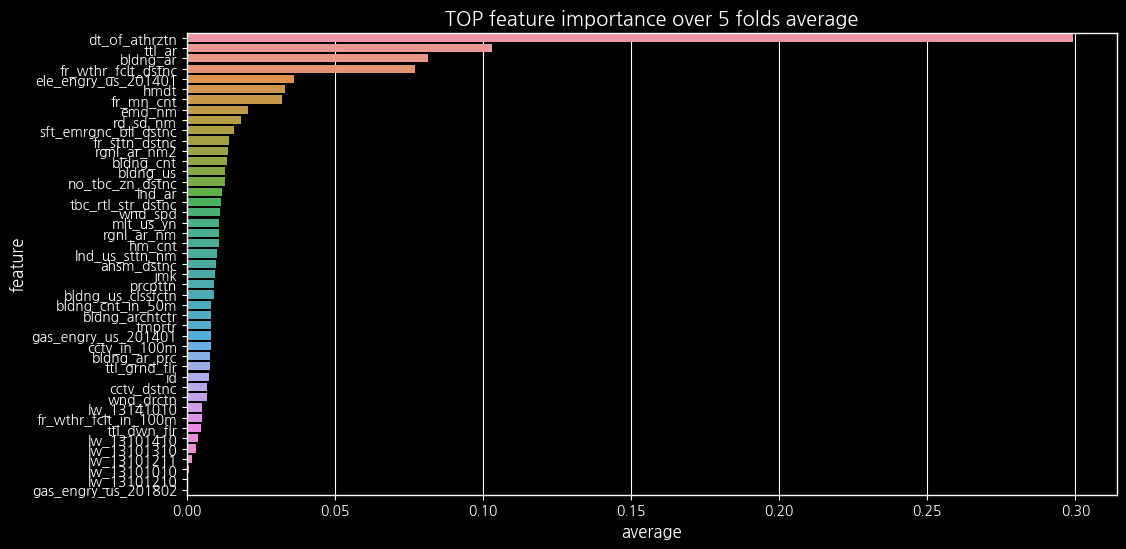

In [12]:
'''v2 - 각 검증셋별 변수중요도의 평균'''
#각 변수의 cross_validation별 평균 변수중요도
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(45), x='average', y='feature');
plt.title('TOP feature importance over {} folds average'.format(folds.n_splits));

In [68]:
'''
log1 = 이상치처리 90% (train)
log2 = 이상치처리 x (train2)
log3 = 이상치처리 95% (train3)
'''
train = train3
sample_var = pd.DataFrame()

sample_ls = list(range(5000,len(train),5000)) + [len(train)]

'''라벨인코딩하기 전에 date변수는 후에 계절변수로도 하나 만들고 시계열변수로도 하나 만들어도 좋을 듯'''
'''모델링할 때 잠깐 제외'''
train.drop(columns ='dt_of_fr',inplace=True)

'''label_encoding'''
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        
'''결측치 일단 -999로 치환 -> 결측치 예측하는 거 유찬이가 만들었을 때 판단'''
train.fillna(-999,inplace=True)
train.drop(columns='id',inplace=True)

for k in sample_ls:
    '''방법론별 정확한 비교를 위해서 데이터는 샘플을 뽑아서 하지 않기로'''
    print('\n sample : ' + str(k))
    data = train.sample(k)
    
    variable = 'fr_yn'

    x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=variable), 
                                                        np.array(data[variable].tolist()), 
                                                        test_size=0.2, 
                                                        stratify=np.array(data[variable].tolist()), 
                                                        random_state=123456)

    NFOLDS = 5
    folds = KFold(n_splits=NFOLDS)
    y_train = pd.Series(y_train)

    columns = x_train.columns
    splits = folds.split(x_train, y_train)
    y_preds = np.zeros(x_test.shape[0])
    y_oof = np.zeros(x_train.shape[0])
    score = 0
    acc=0
    f1=0
    test_score = 0
    test_acc=0
    test_f1=0

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = columns  

    for fold_n, (train_index, valid_index) in enumerate(splits):
        x_train2, x_valid = x_train[columns].iloc[train_index], x_train[columns].iloc[valid_index]
        y_train2, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

        #dtrain = xgb.DMatrix(data=x_train2,label=y_train2)
        #dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

        #모델 생성(classification, regressor)
        xgb_class = xgb.XGBClassifier(n_estimators=100,random_state=0,max_depth=5,eval_metric='auc',class_weight='balanced')
        #모델 학습 (train,valid)
        xgb_class.fit(x_train2,y_train2)

        feature_importances[f'fold_{fold_n + 1}'] = xgb_class.feature_importances_
        y_pred_valid = xgb_class.predict(x_valid)
        y_oof[valid_index] = y_pred_valid

        test_pred = xgb_class.predict(x_test)

        print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
        print(f"Fold {fold_n + 1} | ACC: {accuracy_score(y_valid,y_pred_valid)}")
        print(f"Fold {fold_n + 1} | F1_Score: {f1_score(y_valid,y_pred_valid)}")
        print(f"\nTEST Fold {fold_n + 1} | AUC: {roc_auc_score(y_test, test_pred)}")
        print(f"TEST Fold {fold_n + 1} | ACC: {accuracy_score(y_test, test_pred)}")
        print(f"TEST Fold {fold_n + 1} | F1_Score: {f1_score(y_test, test_pred)}")

        score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
        acc += accuracy_score(y_valid,y_pred_valid) / NFOLDS
        f1 += f1_score(y_valid,y_pred_valid) / NFOLDS

        '''test_fold'''
        test_score += roc_auc_score(y_test, test_pred) / NFOLDS
        test_acc += accuracy_score(y_test, test_pred) / NFOLDS
        test_f1 += f1_score(y_test, test_pred) / NFOLDS

        #y_preds += xgb_class.predict(x_test) / NFOLDS
        #y_test와의 성능 비교는 auc를 평가척도로 놓았기 때문에 그대로 y_test와 auc로 성능을 검증하면 됨
        #근데 의문은 1/0으로 binary로 결과치가 도출되는데 왜 predict_proba로 예측을 하지 않지?

        #데이터 메모리를 최적화하면서 모델링 진행
        del x_train2, x_valid, y_train2, y_valid
        gc.collect()

    print(f"\nMean AUC = {score}")
    print(f"Mean ACC = {acc}")
    print(f"Mean F1_Score = {f1}")
    print(f"\nOut of folds AUC = {roc_auc_score(y_train, y_oof)}")
    print(f"Out of folds AUC = {accuracy_score(y_train,y_oof)}")
    print(f"Out of folds F1_Score = {f1_score(y_train,y_oof)}")
    print(f"\nMean TEST AUC = {test_score}")
    print(f"Mean TEST ACC = {test_acc}")
    print(f"Mean TEST F1_Score = {test_f1}")

    eval_score = [test_score,test_acc,test_f1]
    sample_var['sample_'+str(k)] = eval_score


 sample : 5000
Fold 1 | AUC: 0.6066868607908279
Fold 1 | ACC: 0.89125
Fold 1 | F1_Score: 0.3255813953488372

TEST Fold 1 | AUC: 0.6416128309496247
TEST Fold 1 | ACC: 0.885
TEST Fold 1 | F1_Score: 0.4041450777202073
Fold 2 | AUC: 0.6293656056587091
Fold 2 | ACC: 0.88875
Fold 2 | F1_Score: 0.3945578231292517

TEST Fold 2 | AUC: 0.6276093207363979
TEST Fold 2 | ACC: 0.879
TEST Fold 2 | F1_Score: 0.37305699481865284
Fold 3 | AUC: 0.6629055452835854
Fold 3 | ACC: 0.9075
Fold 3 | F1_Score: 0.4558823529411765

TEST Fold 3 | AUC: 0.6550468650808469
TEST Fold 3 | ACC: 0.89
TEST Fold 3 | F1_Score: 0.43298969072164945
Fold 4 | AUC: 0.6327780846754204
Fold 4 | ACC: 0.88375
Fold 4 | F1_Score: 0.39215686274509803

TEST Fold 4 | AUC: 0.6496975241793943
TEST Fold 4 | ACC: 0.893
TEST Fold 4 | F1_Score: 0.4278074866310161
Fold 5 | AUC: 0.6660260819139324
Fold 5 | ACC: 0.89375
Fold 5 | F1_Score: 0.47204968944099374

TEST Fold 5 | AUC: 0.6515179805071138
TEST Fold 5 | ACC: 0.89
TEST Fold 5 | F1_Score: 0.

Fold 2 | AUC: 0.6443505154639175
Fold 2 | ACC: 0.8876785714285714
Fold 2 | F1_Score: 0.42661804922515956

TEST Fold 2 | AUC: 0.6602943033977517
TEST Fold 2 | ACC: 0.8935714285714286
TEST Fold 2 | F1_Score: 0.4573925710123817
Fold 3 | AUC: 0.6613438996369729
Fold 3 | ACC: 0.8942857142857142
Fold 3 | F1_Score: 0.4608378870673952

TEST Fold 3 | AUC: 0.6634268030819755
TEST Fold 3 | ACC: 0.8941428571428571
TEST Fold 3 | F1_Score: 0.4634322954380884
Fold 4 | AUC: 0.6598677957314439
Fold 4 | ACC: 0.8958928571428572
Fold 4 | F1_Score: 0.4556489262371615

TEST Fold 4 | AUC: 0.6662814197296956
TEST Fold 4 | ACC: 0.8958571428571429
TEST Fold 4 | F1_Score: 0.4705882352941177
Fold 5 | AUC: 0.653576055089657
Fold 5 | ACC: 0.8925
Fold 5 | F1_Score: 0.44052044609665425

TEST Fold 5 | AUC: 0.6629847164329923
TEST Fold 5 | ACC: 0.895
TEST Fold 5 | F1_Score: 0.46389496717724293

Mean AUC = 0.6575074440864114
Mean ACC = 0.8936071428571428
Mean F1_Score = 0.4526378682647837

Out of folds AUC = 0.657457895

In [69]:
sample_var2_out95 = sample_var.T
sample_var2_out95 = sample_var2_out95.rename(columns={0:'AUC',
                                                         1:'ACC',
                                                         2:'F1_Score'})

In [70]:
sample_var2_out95

,AUC,ACC,F1_Score
sample_5000,0.645097,0.887400,0.413017
sample_10000,0.637378,0.885900,0.407209
sample_15000,0.650894,0.893333,0.437773
sample_20000,0.639431,0.887350,0.414264
sample_25000,0.636057,0.891080,0.410403
sample_30000,0.656233,0.893800,0.452137
sample_35000,0.662557,0.894743,0.462802
sample_40000,0.649888,0.892450,0.437945
sample_45000,0.649016,0.893222,0.435908
sample_50000,0.648866,0.895520,0.437545


In [57]:
sample_var2_no_out

,AUC,ACC,F1_Score
sample_5000,0.655493,0.888400,0.447026
sample_10000,0.624182,0.884000,0.379701
sample_15000,0.666593,0.900067,0.475686
sample_20000,0.643948,0.888750,0.424180
sample_25000,0.654264,0.895880,0.449267
sample_30000,0.638635,0.889967,0.412013
sample_35000,0.638101,0.891829,0.414068
sample_40000,0.650204,0.893850,0.440421
sample_45000,0.647266,0.894778,0.434551
sample_50000,0.640225,0.888000,0.414941


In [54]:
sample_var2_out90

,AUC,ACC,F1_Score
sample_5000,0.633998,0.882400,0.395951
sample_10000,0.623692,0.880300,0.379449
sample_15000,0.666737,0.895800,0.472131
sample_20000,0.669252,0.895900,0.475737
sample_25000,0.658725,0.894840,0.456708
sample_30000,0.654319,0.895633,0.446990
sample_35000,0.651270,0.892600,0.442858
sample_40000,0.652378,0.893025,0.444768
sample_45000,0.650486,0.892778,0.439503
sample_50000,0.657382,0.894420,0.452634


In [100]:
sample_var2_no_out.to_csv('sample_no_out.csv',index=True)
sample_var2_out90.to_csv('sample_out90.csv',index=True)
sample_var2_out95.to_csv('sample_out95.csv',index=True)

In [98]:
def eval_plt(eval_columns):
    plt.figure(figsize=(12,8))
    
    plt.plot(sample_var2_no_out[eval_columns],label='이상치 처리X')
    plt.plot(sample_var2_out90[eval_columns],label='90%이상치 처리')
    plt.plot(sample_var2_out95[eval_columns],label = '95%이상치 처리')
    
    plt.xticks(rotation=45)
    if eval_columns=='AUC':
        plt.title('Each Sample AUC compare')
        plt.ylim(0.6,0.7)
    elif eval_columns=='ACC':
        plt.ylim(0.87,0.91)
        plt.title('Each Sample ACC compare')
    else:
        plt.ylim(0.35,0.5)
        plt.title('Each Sample F1_Score compare')
    plt.legend()

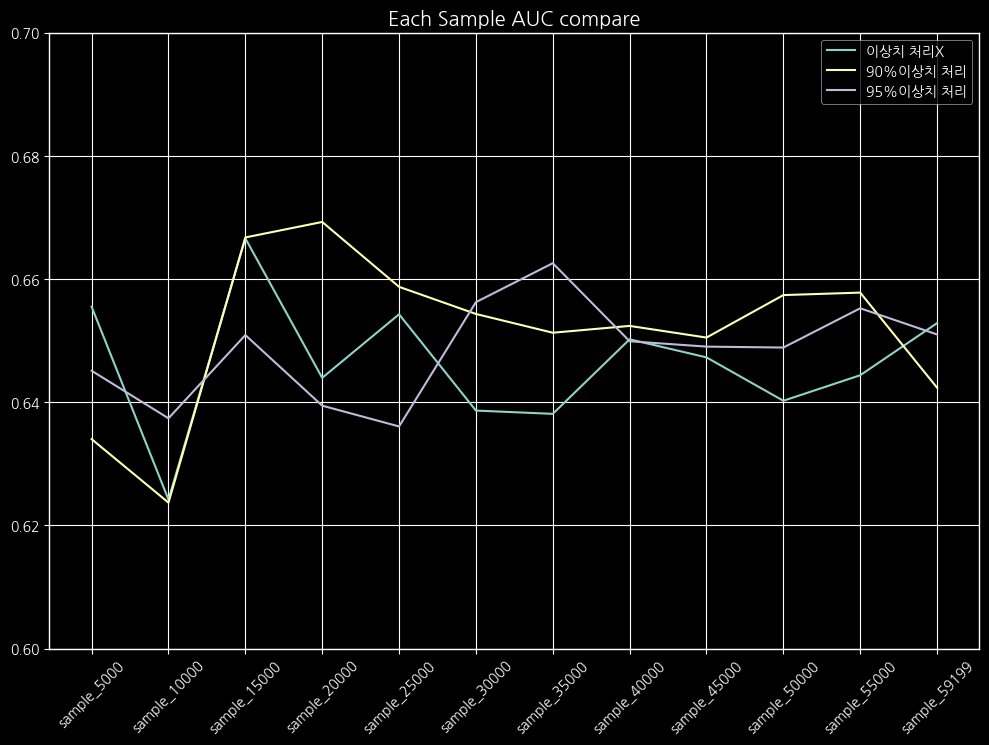

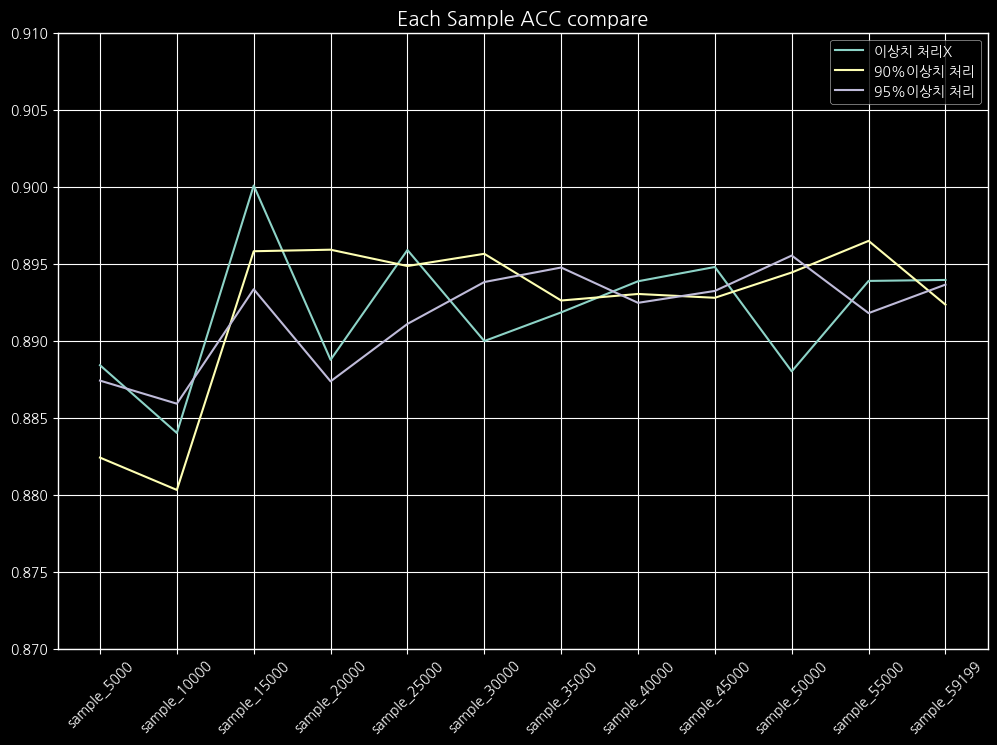

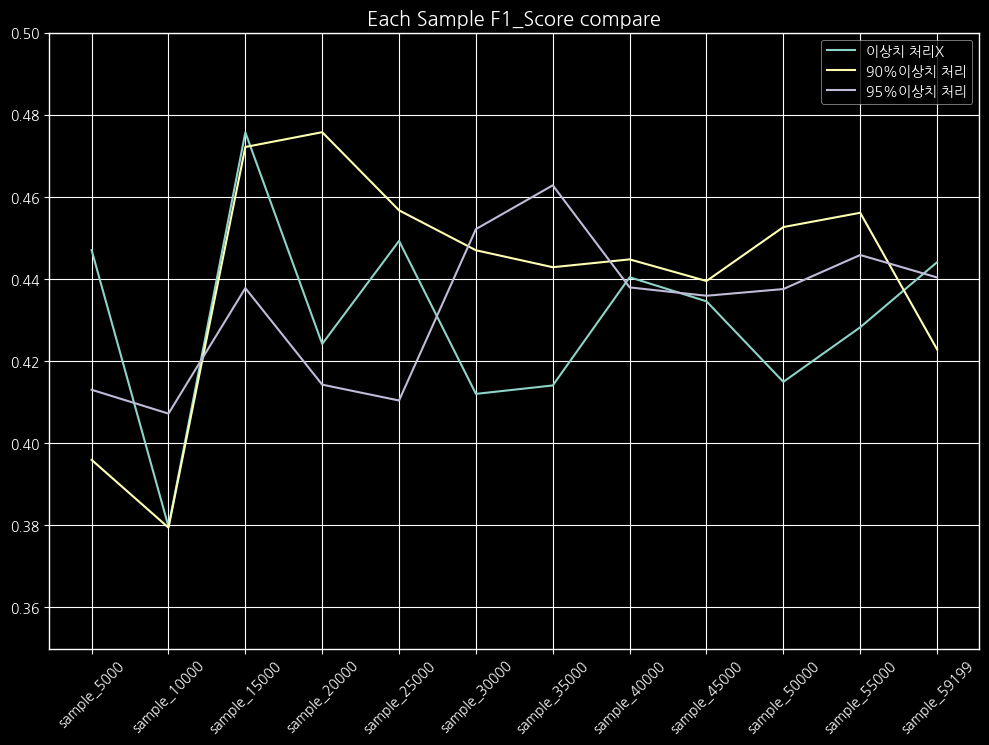

In [99]:
for i in ['AUC','ACC','F1_Score']:
    eval_plt(i)